<a href="https://colab.research.google.com/github/shreyans312/EV_Charging_Station_Dynamic_Pricing/blob/main/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
from functools import reduce
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/EV Charging Station Dynamic Pricing/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
duration = pd.read_csv(f'{data_dir}/duration.csv', index_col='time', parse_dates=True)
volume = pd.read_csv(f'{data_dir}/volume.csv', index_col='time', parse_dates=True)
e_price = pd.read_csv(f'{data_dir}/e_price.csv', index_col='time', parse_dates=True)
s_price = pd.read_csv(f'{data_dir}/s_price.csv', index_col='time', parse_dates=True)
occupancy = pd.read_csv(f'{data_dir}/occupancy.csv', index_col='time', parse_dates=True)
weather = pd.read_csv(f'{data_dir}/weather_central.csv')
zone_info = pd.read_csv(f'{data_dir}/inf.csv')
zone_info = zone_info.rename(columns={'TAZID': 'zone_id'})
zone_info['zone_id'] = zone_info['zone_id'].astype(str)

zones = list(set(duration.columns) & set(volume.columns) &
             set(e_price.columns) & set(s_price.columns) & set(occupancy.columns))

duration = duration[zones]
volume = volume[zones]
e_price = e_price[zones]
s_price = s_price[zones]
occupancy = occupancy[zones]

def melt_df(df, name):
    return df.reset_index().melt(id_vars='time', var_name='zone_id', value_name=name)

df_list = [
    melt_df(duration, 'duration'),
    melt_df(volume, 'volume'),
    melt_df(e_price, 'e_price'),
    melt_df(s_price, 's_price'),
    melt_df(occupancy, 'occupancy')
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['time', 'zone_id']), df_list)

merged_df['time'] = pd.to_datetime(merged_df['time'])
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['weekday'] = merged_df['time'].dt.weekday
merged_df['is_peak'] = merged_df.groupby('zone_id')['duration'].transform(
    lambda x: (x >= x.quantile(0.80)).astype(int)
)

weather['time'] = pd.to_datetime(weather['time'])
merged_df = pd.merge(merged_df, weather, on='time', how='left')
merged_df = pd.merge(merged_df, zone_info, on='zone_id', how='left')
zone_info = pd.read_csv(f'{data_dir}/inf.csv')
zone_info = zone_info.rename(columns={'TAZID': 'zone_id'})

merged_df.sort_values(by=['zone_id', 'time'], inplace=True)
merged_df['duration_24h_mean'] = merged_df.groupby('zone_id')['duration'].transform(lambda x: x.rolling(24, min_periods=1).mean())
merged_df['volume_24h_mean'] = merged_df.groupby('zone_id')['volume'].transform(lambda x: x.rolling(24, min_periods=1).mean())

distance = pd.read_csv(f'{data_dir}/zone_dist.csv', index_col=0)
distance.columns = distance.columns.astype(str)
distance.index = distance.index.astype(str)

# Inverting and Normalizing distances
dist_matrix = distance.copy()
np.fill_diagonal(dist_matrix.values, np.nan)
weights = 1 / dist_matrix
weights = weights.fillna(0)
duration_wide = merged_df.pivot(index='time', columns='zone_id', values='duration')
volume_wide = merged_df.pivot(index='time', columns='zone_id', values='volume')
neighbor_duration = duration_wide.dot(weights.T) / weights.sum(axis=1)
neighbor_volume = volume_wide.dot(weights.T) / weights.sum(axis=1)
neighbor_duration = neighbor_duration.reset_index().melt(id_vars='time', var_name='zone_id', value_name='neighbor_duration')
neighbor_volume = neighbor_volume.reset_index().melt(id_vars='time', var_name='zone_id', value_name='neighbor_volume')

merged_df = pd.merge(merged_df, neighbor_duration, on=['time', 'zone_id'], how='left')
merged_df = pd.merge(merged_df, neighbor_volume, on=['time', 'zone_id'], how='left')


In [15]:
output_path = f'{data_dir}/urban_ev_combined.csv'
merged_df.to_csv(output_path, index=False)
print(f"Merged dataset saved to: {output_path}")
print("Shape:", merged_df.shape)

Merged dataset saved to: /content/drive/MyDrive/EV Charging Station Dynamic Pricing/data//urban_ev_combined.csv
Shape: (1194600, 25)


In [16]:
file_path = '/content/drive/MyDrive/EV Charging Station Dynamic Pricing/data/urban_ev_combined.csv'
df = pd.read_csv(file_path, parse_dates=['time'])
print(df.head())

                 time  zone_id   duration      volume   e_price   s_price  \
0 2022-09-01 00:00:00     1000  60.833333  330.458333  0.873429  0.739429   
1 2022-09-01 01:00:00     1000  57.833333  311.208333  0.873429  0.739429   
2 2022-09-01 02:00:00     1000  62.250000  332.208333  0.873429  0.739429   
3 2022-09-01 03:00:00     1000  65.250000  345.041667  0.873429  0.739429   
4 2022-09-01 04:00:00     1000  63.166667  336.583333  0.873429  0.739429   

   occupancy  hour  weekday  is_peak  ...    Td   longitude   latitude  \
0   0.381443     0        3        1  ...  24.9  114.269504  22.720186   
1   0.298969     1        3        1  ...  24.9  114.269504  22.720186   
2   0.360825     2        3        1  ...  24.9  114.269504  22.720186   
3   0.355670     3        3        1  ...  24.9  114.269504  22.720186   
4   0.319588     4        3        1  ...  24.9  114.269504  22.720186   

   charge_count         area  perimeter  duration_24h_mean  volume_24h_mean  \
0           2

In [17]:
print(df.isna().sum())
df.info()

time                 0
zone_id              0
duration             0
volume               0
e_price              0
s_price              0
occupancy            0
hour                 0
weekday              0
is_peak              0
T                    0
P0                   0
P                    0
U                    0
nRAIN                0
Td                   0
longitude            0
latitude             0
charge_count         0
area                 0
perimeter            0
duration_24h_mean    0
volume_24h_mean      0
neighbor_duration    0
neighbor_volume      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194600 entries, 0 to 1194599
Data columns (total 25 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   time               1194600 non-null  datetime64[ns]
 1   zone_id            1194600 non-null  int64         
 2   duration           1194600 non-null  float64       
 3   volume   

# **Feature Understanding and Relation Analysis**

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

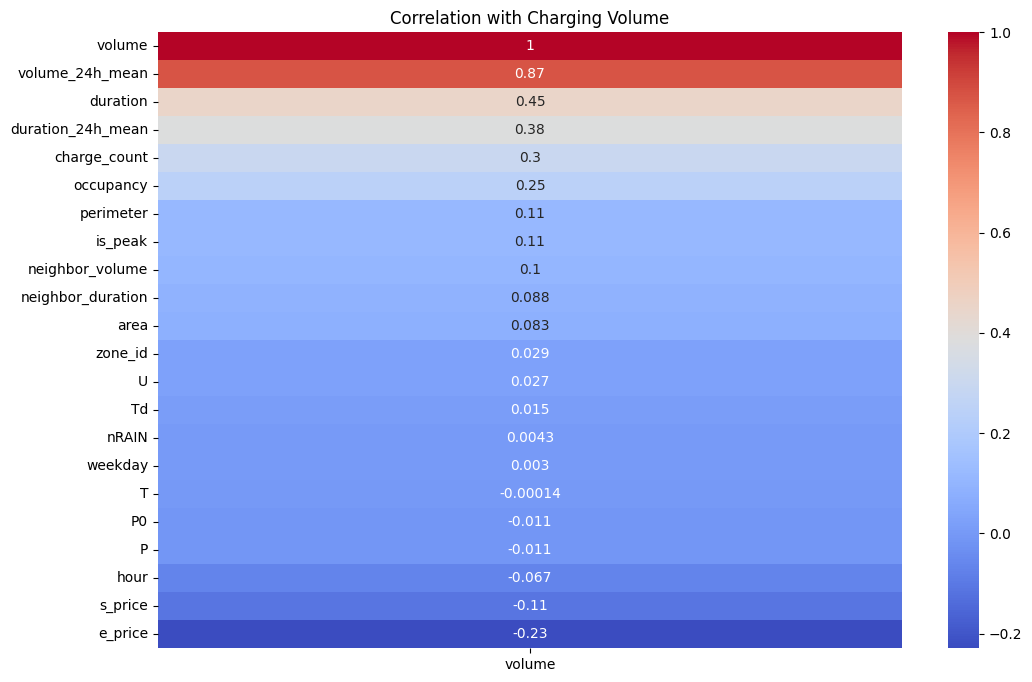

In [19]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['longitude', 'latitude'])  # geo not useful directly
corr = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr[['volume']].sort_values(by='volume', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Charging Volume')
plt.show()

**Time series trends (for a single zone)**

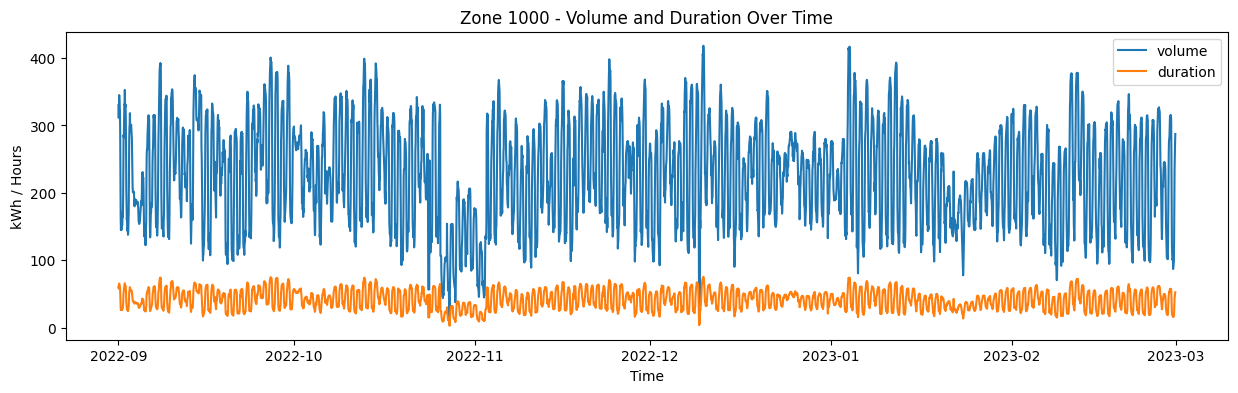

In [20]:
zone = df['zone_id'].unique()[0]
df_zone = df[df['zone_id'] == zone]

plt.figure(figsize=(15, 4))
plt.plot(df_zone['time'], df_zone['volume'], label='volume')
plt.plot(df_zone['time'], df_zone['duration'], label='duration')
plt.title(f"Zone {zone} - Volume and Duration Over Time")
plt.xlabel("Time")
plt.ylabel("kWh / Hours")
plt.legend()
plt.show()

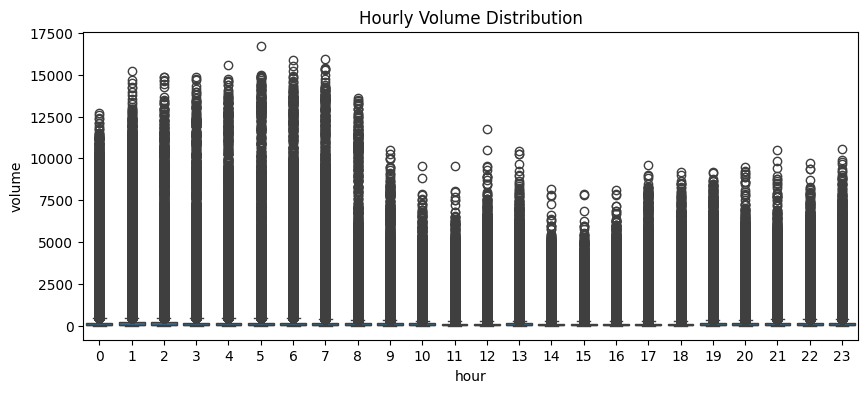

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='hour', y='volume')
plt.title('Hourly Volume Distribution')
plt.show()

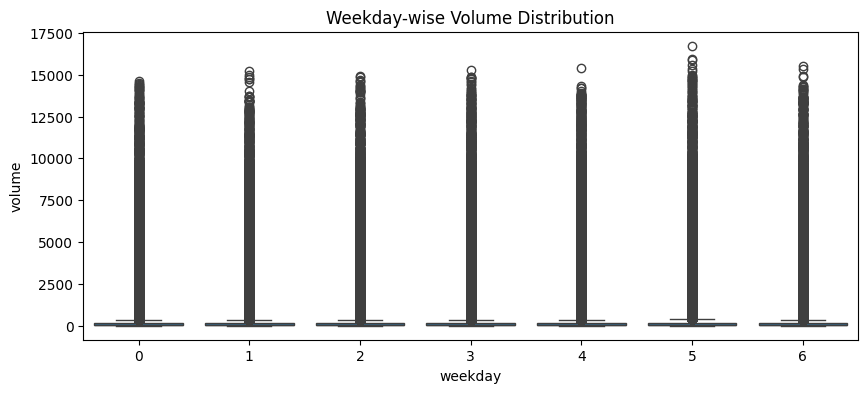

In [22]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='weekday', y='volume')
plt.title('Weekday-wise Volume Distribution')
plt.show()


**Weather Dependencies**

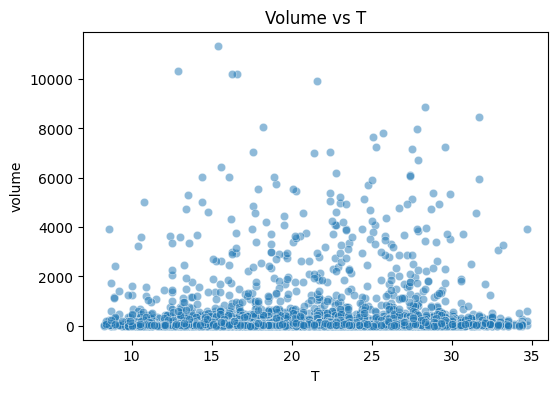

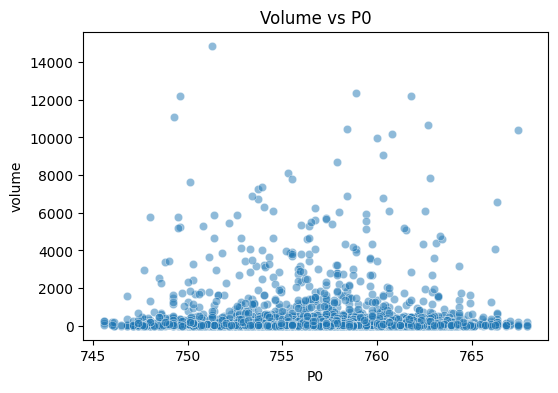

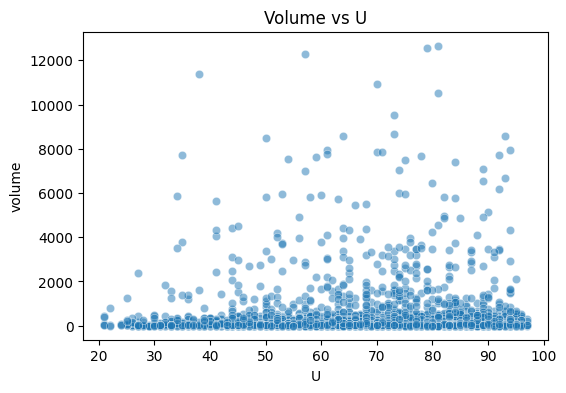

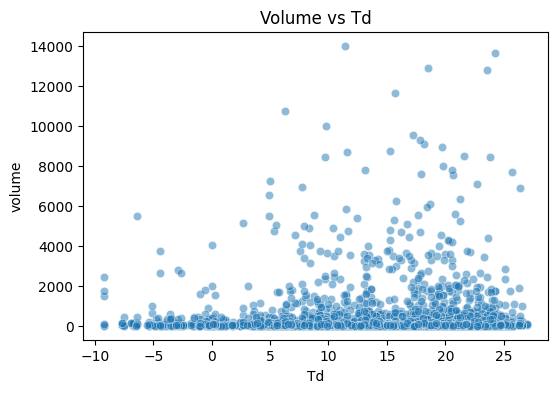

In [23]:
weather_vars = ['T', 'P0', 'U', 'Td']

for var in weather_vars:
    if var in df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df.sample(5000), x=var, y='volume', alpha=0.5)
        plt.title(f'Volume vs {var}')
        plt.show()

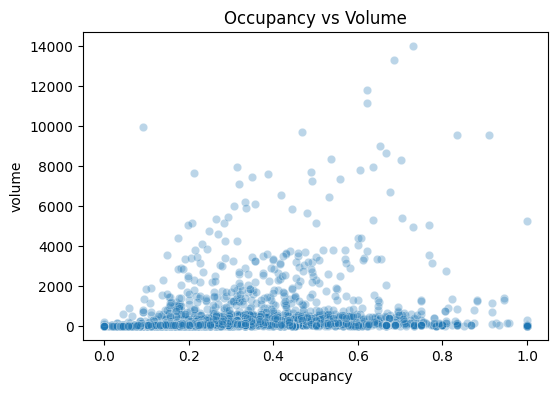

In [24]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df.sample(5000), x='occupancy', y='volume', alpha=0.3)
plt.title('Occupancy vs Volume')
plt.show()


# **Feature importance using Random Forest**

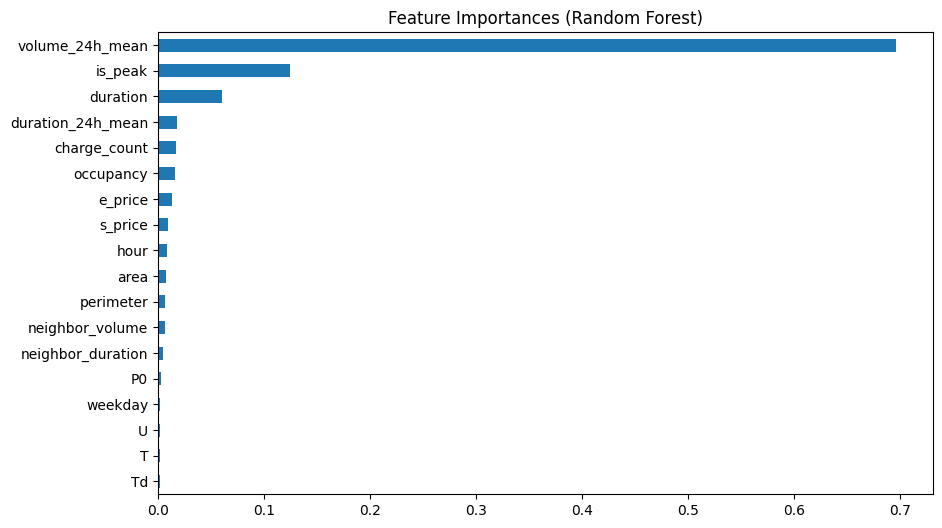

In [27]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
features = [
    'duration', 'e_price', 's_price', 'occupancy',
    'hour', 'weekday', 'is_peak',
    'duration_24h_mean', 'volume_24h_mean',
    'neighbor_duration', 'neighbor_volume',
    'T', 'P0', 'U', 'Td',
    'charge_count', 'area', 'perimeter'
]

df_sampled = df.dropna(subset=features + ['volume']).sample(15000, random_state=42)

X = df_sampled[features]
y = df_sampled['volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [28]:
print(feature_importances)

volume_24h_mean      0.696334
is_peak              0.124149
duration             0.060780
duration_24h_mean    0.017866
charge_count         0.016794
occupancy            0.015758
e_price              0.013214
s_price              0.009684
hour                 0.008795
area                 0.007281
perimeter            0.006944
neighbor_volume      0.006303
neighbor_duration    0.004707
P0                   0.002599
weekday              0.002255
U                    0.002231
T                    0.002192
Td                   0.002113
dtype: float64


# **Selected Features for LSTM**

[
    'volume_24h_mean',
    'is_peak',
    'duration',
    'duration_24h_mean',
    'charge_count',
    'occupancy',
    'e_price',
    's_price',
    'hour',
    'area'
]